9/17-9/18/2023

This is code for the Kaggle Titanic Competition. Before writing this code, I made 21 submissions to the competition, with my highest test accuracy being 0.77511, landing me 7151th place (although there are people in the low 3000s with this score). This code is me taking a step back from just trying different models and random search, and analyzing feature importance more.

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
from scipy.stats import randint

In [2]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
train_set.dropna(subset=["Embarked"], inplace=True)
survived = np.array(pd.DataFrame(train_set["Survived"].copy())).ravel()

nec_data = train_set.copy()
nec_data = train_set.drop("Name", axis=1) # string and too individual
nec_data = nec_data.drop("PassengerId", axis=1) # too individual

ids2 = np.array(test_set["PassengerId"].copy()).ravel() # contest submission requires passenger ids

In [4]:
train_set["Cabin"].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [5]:
train_set["Ticket"].head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

For my first go-around, I'm gonna remove Cabin because of how many null values there are.
Next time (if there needs to be one), I might split the dataset based on Pclass, change the "Cabin" attribute to be just the first letter, and impute.
This is because I think the floor level might be indicative of socioeconomic level too.

I'm dropping Ticket no matter what because it's a pretty weird feature. Some instances have characters, some are just 5 numbers, etc.

In [6]:
nec_data = nec_data.drop("Cabin", axis=1)
nec_data = nec_data.drop("Ticket", axis=1)

nec_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


I did a log transform on SibSp, Parch, and Fare for my first few tries, in order to remove the tail in the data. However, I'm looking for feature importance, so looking at that with mostly unchanged data might be fruitful.

In [7]:
nec_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


In [8]:
text_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
num_norm_pipeline = make_pipeline(SimpleImputer(strategy="median"))
preprocess = ColumnTransformer([
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)
pre_nec_data = preprocess.fit_transform(nec_data)
pre_nec_data = pd.DataFrame(pre_nec_data)
pre_nec_data.head(10)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,1.0,0.0,0.0,0.0,1.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,1.0,0.0,0.0,0.0,1.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,0.0,1.0,0.0,0.0,1.0,0.0,3.0,35.0,0.0,0.0,8.0500
5,0.0,1.0,0.0,1.0,0.0,0.0,3.0,28.0,0.0,0.0,8.4583
6,0.0,1.0,0.0,0.0,1.0,0.0,1.0,54.0,0.0,0.0,51.8625
7,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,3.0,1.0,21.0750
8,1.0,0.0,0.0,0.0,1.0,1.0,3.0,27.0,0.0,2.0,11.1333
9,1.0,0.0,1.0,0.0,0.0,1.0,2.0,14.0,1.0,0.0,30.0708


After the fit_transform, the new column order is is_female, is_male, from_Cherbourg(C), from_Queenstown(Q), from_Southampton(S), Survived, Pclass, Age, SibSp, Parch, Fare

Now, after the one-hot encoding, is_female and Survived look the exact same. However, I can tell them apart because the first two columns in the transformed data are the exact opposites of each other (this is further proven by using .corr(), where is_female has a negative correlation of -1 with is_male, and vice versa). It also makes sense that the one-hot encoded attributes are one side of the data and the numerical attributes are on the other (in the same order of Survived, PClass...)

Before moving forward, I should scale the numerical attributes.

In [9]:
text_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
num_norm_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
preprocess = ColumnTransformer([
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)
pre_nec_data = preprocess.fit_transform(nec_data)
pre_nec_data = pd.DataFrame(pre_nec_data)
pre_nec_data.head(10)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,1.0,0.0,0.0,1.0,-0.786961,0.825209,-0.563674,0.431350,-0.474326,-0.500240
1,1.0,0.0,1.0,0.0,0.0,1.270711,-1.572211,0.669217,0.431350,-0.474326,0.788947
2,1.0,0.0,0.0,0.0,1.0,1.270711,0.825209,-0.255451,-0.475199,-0.474326,-0.486650
3,1.0,0.0,0.0,0.0,1.0,1.270711,-1.572211,0.438050,0.431350,-0.474326,0.422861
4,0.0,1.0,0.0,0.0,1.0,-0.786961,0.825209,0.438050,-0.475199,-0.474326,-0.484133
5,0.0,1.0,0.0,1.0,0.0,-0.786961,0.825209,-0.101340,-0.475199,-0.474326,-0.475913
6,0.0,1.0,0.0,0.0,1.0,-0.786961,-1.572211,1.902108,-0.475199,-0.474326,0.397946
7,0.0,1.0,0.0,0.0,1.0,-0.786961,0.825209,-2.104788,2.244449,0.765897,-0.221900
8,1.0,0.0,0.0,0.0,1.0,1.270711,0.825209,-0.178396,-0.475199,2.006119,-0.422057
9,1.0,0.0,1.0,0.0,0.0,1.270711,-0.373501,-1.180120,0.431350,-0.474326,-0.040787


In [10]:
nec_matrix = pre_nec_data.corr()
nec_titles = ["is_female", "is_male", "from_Cherbourg(C)", "from_Queenstown(Q)", "from_Southampton(S)", "Survived", "Pclass", 
                               "Age", "SibSp", "Parch", "Fare"]
for k in range(len(nec_titles)):
    print(f"{nec_titles[k]}, {nec_matrix[5][k]}")

is_female, 0.5415849155511682
is_male, -0.5415849155511685
from_Cherbourg(C), 0.16996596681270035
from_Queenstown(Q), 0.004535728723985596
from_Southampton(S), -0.1517770485943329
Survived, 1.0
Pclass, -0.33554885935682593
Age, -0.06982170767891918
SibSp, -0.034039998796749
Parch, 0.08315078366620231
Fare, 0.25529046130469946


Genders are obviously the most correlated to Survived. Second place is PClass, followed by Fare and Embarked (from_Cherbourg, etc.). I suspected that SibSp and Parch would be pretty unimportant, but it seems that age is also pretty unimportant. In previous attempts, I only worked with Gender, Age, and PClass, so this new knowledge might lead to a better performing model.

As an aside, I want to see if using logarithms changes anything.

[]

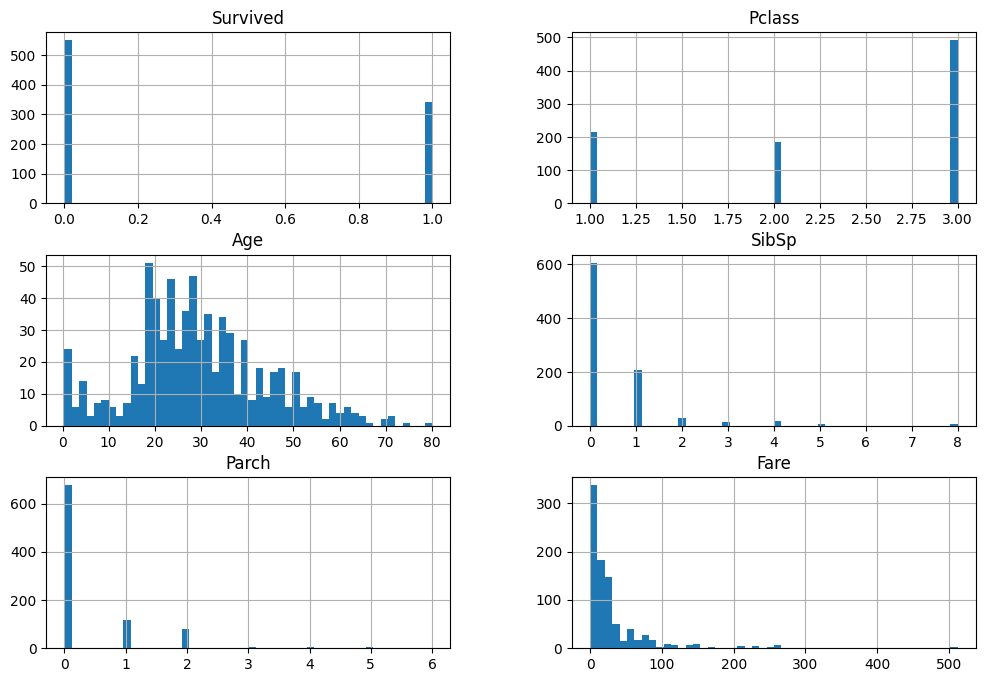

In [11]:
nec_num = nec_data.select_dtypes(include=[np.number])
nec_num.hist(bins=50, figsize=(12, 8))
plt.plot()

In [28]:
def safe_log(x):
    return np.log(x + 1e-10)
#thanks to ChatGPT 3.5 for this function

log_transformer = FunctionTransformer(func=safe_log, inverse_func=np.exp)
num_tail_pipeline = make_pipeline(SimpleImputer(strategy="median"), log_transformer, StandardScaler())
preprocess2 = ColumnTransformer([
    ("tail", num_tail_pipeline, ["SibSp", "Parch", "Fare"]), # not for Pclass, since it's basically ordinally encoded
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)

pre_nec_data_2 = preprocess2.fit_transform(nec_data)
pre_nec_data_2 = pd.DataFrame(pre_nec_data_2)
pre_nec_data_2.head(10)

,0,1,2,3,4,5,6,7,8,9,10
0,1.435255,-0.561198,-0.150127,0.0,1.0,0.0,0.0,1.0,-0.786961,0.825209,-0.563674
1,1.435255,-0.561198,0.508512,1.0,0.0,1.0,0.0,0.0,1.270711,-1.572211,0.669217
2,-0.683094,-0.561198,-0.124475,1.0,0.0,0.0,0.0,1.0,1.270711,0.825209,-0.255451
3,1.435255,-0.561198,0.423652,1.0,0.0,0.0,0.0,1.0,1.270711,-1.572211,0.438050
4,-0.683094,-0.561198,-0.119965,0.0,1.0,0.0,0.0,1.0,-0.786961,0.825209,0.438050
5,-0.683094,-0.561198,-0.105708,0.0,1.0,0.0,1.0,0.0,-0.786961,0.825209,-0.101340
6,-0.683094,-0.561198,0.416857,0.0,1.0,0.0,0.0,1.0,-0.786961,-1.572211,1.902108
7,1.536326,1.745184,0.157365,0.0,1.0,0.0,0.0,1.0,-0.786961,0.825209,-2.104788
8,-0.683094,1.814614,-0.026524,1.0,0.0,0.0,0.0,1.0,1.270711,0.825209,-0.178396
9,1.435255,-0.561198,0.259797,1.0,0.0,1.0,0.0,0.0,1.270711,-0.373501,-1.180120


Now the order of columns is SibSp, Parch, Fare, is_female, is_male, from_Cherbourg(C), from_Queenstown(Q), from_Southampton(S), Survived, Pclass, Age.

In [29]:
nec_matrix2 = pre_nec_data_2.corr()
nec_titles2 = ["SibSp", "Parch", "Fare", "is_female", "is_male", "from_Cherbourg(C)", "from_Queenstown(Q)", "from_Southampton(S)", "Survived", "Pclass", 
                               "Age"]
for k in range(len(nec_titles2)):
    print(f"{nec_titles2[k]}, {nec_matrix2[8][k]}")

SibSp, 0.11338256465947266
Parch, 0.14780262343279407
Fare, 0.16763827174800014
is_female, 0.5415849155511682
is_male, -0.5415849155511685
from_Cherbourg(C), 0.16996596681270035
from_Queenstown(Q), 0.004535728723985596
from_Southampton(S), -0.1517770485943329
Survived, 1.0
Pclass, -0.33554885935682593
Age, -0.06982170767891918


This didn't change things. SibSp and Parch are more correlated now, and Fare is less correlated. However, the "ranking" of how correlated these features are remains the same.

In [14]:
imp_data = train_set[["Sex", "Embarked", "Pclass", "Fare"]] # as in "important data"
preprocess3 = ColumnTransformer([
    ("tail", num_tail_pipeline, ["Fare"]),
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)
lr_clf = Pipeline([("pre", preprocess3), ("clf", LogisticRegression(random_state=446))])
lr_clf.fit(imp_data, survived)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('tail',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function safe_log at 0x000002050555F130>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Fare', 'Pclass']),
                                                 ('text',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020501B5F9A0>)])),
                ('clf', LogisticRegression(random_state=446))])

In [15]:
print(lr_clf.predict(imp_data[:10]))
print(survived[:10])

[0 1 1 1 0 0 0 0 1 1]
[0 1 1 1 0 0 0 0 1 1]


In [16]:
rmse = -cross_val_score(lr_clf, imp_data, survived, scoring="neg_root_mean_squared_error", cv=10)
print(np.average(rmse))

0.47854330100938036


In [17]:
# test_pred = lr_clf.predict(test_set)
# with open('sacreddeer_titanic_new_submission_1.csv', 'w', newline='') as f:
#     # create the csv writer
#     writer = csv.writer(f)
#     writer.writerow(["PassengerId", "Survived"])
#     for k in range(len(ids2)):
#         # write a row to the csv file
#         writer.writerow([ids2[k], test_pred[k]])

After that, only got a test accuracy of 0.75119. With this, I realized Fare and Embarked, having pretty low correlation coefficients, shouldn't have even been included. I'll try again with just Sex and Pclass.

In [18]:
imp_data2 = train_set[["Sex", "Pclass"]] # as in "important data"
lr_clf2 = Pipeline([("pre", preprocess), ("clf", LogisticRegression(random_state=446))])
lr_clf2.fit(imp_data, survived)
rmse = -cross_val_score(lr_clf2, imp_data2, survived, scoring="neg_root_mean_squared_error", cv=10)
print(np.average(rmse))

0.4612560463684951


In [19]:
# test_pred = lr_clf2.predict(test_set)
# with open('sacreddeer_titanic_new_submission_2.csv', 'w', newline='') as f:
#     # create the csv writer
#     writer = csv.writer(f)
#     writer.writerow(["PassengerId", "Survived"])
#     for k in range(len(ids2)):
#         # write a row to the csv file
#         writer.writerow([ids2[k], test_pred[k]])

After this, got a test accuracy of 0.76555, the score my very first model submission got. Now I'm going to try hyperparameter tuning.

In [20]:
randarr = np.zeros(20)
for k in range(len(randarr)):
    randarr[k] = random.uniform(0.01, 0.05)
param_distribs = {"clf__C": randarr}
rdm_search = RandomizedSearchCV(
    lr_clf2, param_distributions=param_distribs, n_iter=10, cv=3, scoring="neg_root_mean_squared_error"
)
rdm_search.fit(imp_data2, survived)
final_lr_model = rdm_search.best_estimator_
print(final_lr_model["clf"])

LogisticRegression(C=0.014761116376898769, random_state=446)


In [21]:
# test_pred = final_lr_model.predict(test_set)
# with open('sacreddeer_titanic_new_submission_3.csv', 'w', newline='') as f:
#     # create the csv writer
#     writer = csv.writer(f)
#     writer.writerow(["PassengerId", "Survived"])
#     for k in range(len(ids2)):
#         # write a row to the csv file
#         writer.writerow([ids2[k], test_pred[k]])

This got me a test accuracy of 0.77511, the same as the very best score I've ever gotten in this competition. Considering I probably need to move onto another model, I'm going to try removing PClass. It only had a correlation coefficient of 0.33 anyway, and the commonly agreed upon metric is |correlation| > 0.5 indicates an actual correlation.

In [22]:
imp_data3 = train_set[["Sex"]] 
lr_clf3 = Pipeline([("pre", preprocess), ("clf", LogisticRegression(random_state=446))])
lr_clf3.fit(imp_data, survived)
rmse = -cross_val_score(lr_clf3, imp_data3, survived, scoring="neg_root_mean_squared_error", cv=10)
print(np.average(rmse))

0.4612560463684951


In [23]:
randarr = np.zeros(20)
for k in range(len(randarr)):
    randarr[k] = random.uniform(0.01, 0.1)
param_distribs = {"clf__C": randarr}
rdm_search = RandomizedSearchCV(
    lr_clf3, param_distributions=param_distribs, n_iter=10, cv=3, scoring="neg_root_mean_squared_error"
)
rdm_search.fit(imp_data2, survived)
final_lr_model2 = rdm_search.best_estimator_
print(final_lr_model2["clf"])

LogisticRegression(C=0.01159333403271744, random_state=446)


In [24]:
print(np.average(-cross_val_score(final_lr_model2, imp_data3, survived, scoring="neg_root_mean_squared_error", cv=10)))

0.4612560463684951


In [25]:
# test_pred = final_lr_model.predict(test_set)
# with open('sacreddeer_titanic_new_submission_4.csv', 'w', newline='') as f:
#     # create the csv writer
#     writer = csv.writer(f)
#     writer.writerow(["PassengerId", "Survived"])
#     for k in range(len(ids2)):
#         # write a row to the csv file
#         writer.writerow([ids2[k], test_pred[k]])

Funnily enough, same score as the last one. Maybe gender is all that's really necessary. One more thing before I move to random forests and feature importance. I want to see how many people who survived are female and male, and how many have the different Pclass ratings.

In [49]:
print(nec_data["Sex"][829])

KeyError: 829

In [60]:
num_m = 0
num_f = 0
tot = 0
for k in range(len(survived)):
    if k != 829 and survived[k] == 1:
        tot += 1
        if nec_data["Sex"][k] == "male":
            num_m += 1
        else:
            num_f += 1
print(f"Men: {num_m} out of {tot}") # number of males that survived over number of survivors
print(f"Women: {num_f} out of {tot}")       

Men: 212 out of 339
Women: 127 out of 339


The whole "women and children" thing and previous looks at the data makes me think this can't be right. This led me to think that the number of men on the ship might just be higher than the number of women, but women were still more likely to survive. This led to the below test:

In [54]:
tot_m = 0
tot_f = 0
for k in range(len(survived)):
    if k != 829 and k != 61: #these indices just don't work for whatever reason
        if nec_data["Sex"][k] == "male":
            tot_m += 1
        else:
            tot_f += 1
print(f"Male Survival Rate: {num_m/tot_m}") # number of males that survived over number of males on the ship
print(f"Female Survival Rate: {num_f/tot_f}")       

Male Survival Rate: 0.36869565217391304
Female Survival Rate: 0.40705128205128205


As I thought, there was a higher female survival rate.

In [53]:
num_1 = 0
num_2 = 0
num_3 = 0
tot_1 = 0
tot_2 = 0
tot_3 = 0
for k in range(len(survived)):
     if k != 829 and k != 61:
        if nec_data["Pclass"][k] == 1:
            tot_1 += 1
            if survived[k] == 1:
                num_1 += 1
        elif nec_data["Pclass"][k] == 2:
            tot_2 += 1
            if survived[k] == 1:
                num_2 += 1
        else:
            tot_3 += 1
            if survived[k] == 1:
                num_3 += 1 
        
print(f"Upper Survival Rate: {num_1 / tot_1}")
print(f"Middle Survival Rate: {num_2 / tot_2}")
print(f"Lower Survival Rate: {num_3 / tot_3}")          

Upper Survival Rate: 0.38497652582159625
Middle Survival Rate: 0.3641304347826087
Lower Survival Rate: 0.3877551020408163


The above test further show Pclass doesn't really indicate anything.